### The wave equation (1D case)

#### The equation
\begin{equation}
\begin{cases}
    u_{tt} - cu_{xx} = 0 \quad \text{in} \ x\in[-L,L],\ t>0 \\
    u(x,0) = f(x),\  \ u_t(x,0) = g(x)
\end{cases}
\end{equation}
Then the above PDE has the solution
$$
u(x,t) = \frac{1}{2}(f(x+ct)+f(x-ct)) + \frac{1}{2c}\int^{x+ct}_{x-ct}g(y)~dy
$$

#### (a) The problem
In the above equation, we assume the initial position and velocity are 
\begin{equation}
f(x) = sin(\pi x),\quad g(x) = 0.
\end{equation}
We also have the boundary conditions
\begin{equation}
u(-L,t)=0, \quad u(L,t)=0.
\end{equation}
Then, it has the solution
$$
u(x,t) = sin(\pi x)\cos(2\pi t)
$$

### (1) Prepare Data

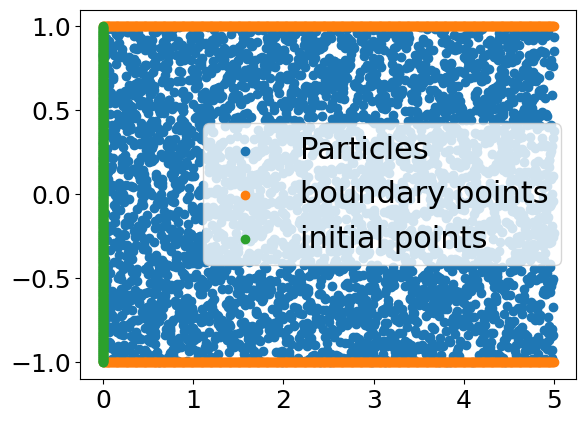

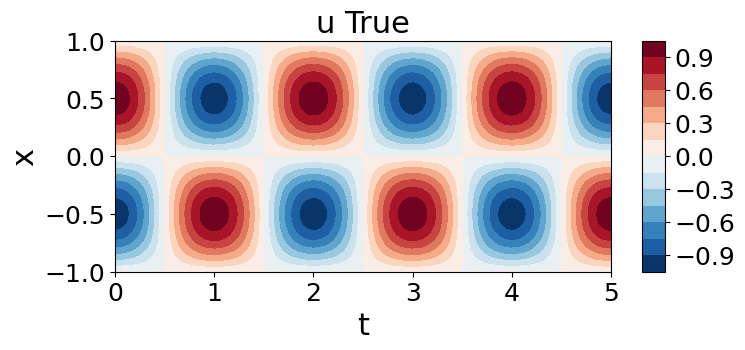

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Waves_1d'
######################################
# Load the problem (wave 1d)
######################################
from Problems.Wave.Wave_1d import Problem
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
tT = 5.
#
problem = Problem(freq=1.*np.pi)
xt_test = pointGen.inner_point(nx=50, nt=50, method='mesh', tT=[tT])
u_test = problem._u_star(xt_test)
######################################
# Generate training data
######################################
Nx_center, Nt_center, N_init, N_bd = 1, 4000, 500, 500 
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=Nx_center, nt=Nt_center, Rmax=1e-4, Rmin=1e-4, method='hypercube', tT=[tT])
#### (initial points)
xt_init = pointGen.init_point(num_sample=N_init, t_stamp=[0.], method='mesh')
#### (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=N_bd, tT=[tT])
xt_bd = torch.cat([xt_lb, xt_ub], dim=0)
#########################################
plt.figure()
plt.scatter(tc_train[...,0], xc_train[...,0], label='Particles')
plt.scatter(xt_bd[:,-1], xt_bd[:,0], label='boundary points')
plt.scatter(xt_init[:,-1], xt_init[:,0], label='initial points')
plt.legend()
plt.show()
#######
from Utils.PlotFigure import Plot
Plot.show_1dt(xt_test, u_test, title='u True', tT=tT, lb=-1., ub=1.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=11, 
    dataType=dtype).get_testFun()

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        #
        self.solver.getLoss = torch.nn.MSELoss()
        
    def Loss_pde(self, xc=None, tc=None, R=None):
        '''Define the PDE loss
        '''
        # ################################## 
        xc, tc, R = pointGen.weight_centers(n_center=1, nt=2000, Rmax=1e-3, Rmin=1e-3, method='hypercube', tT=[tT])
        xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        t = tc.repeat(1, self.n_grid, 1)
        x = Variable(x.reshape(-1, 1), requires_grad=True)
        t = Variable(t.reshape(-1, 1), requires_grad=True)
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 1)
        ##########################################
        u = self.model_u(xt)
        du = self.solver.grad(u, [x, t])
        du_tt = self.solver.grad(du[1], [t])[0]
        ########################################### weawk form
        res1 = du_tt * v + du[0] * dv
        res1 = torch.mean(res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ###########################################
        loss = self.solver.getLoss(res1, torch.zeros_like(res1))
        
        return loss * 1.

    def Loss_bd(self):
        ''' '''
        loss = 0.
        ############### The initial condition
        xt = Variable(xt_init, requires_grad=True).to(self.device)
        u, u_true = self.model_u(xt), problem._u_star(xt)
        dut = self.solver.grad(u, [xt])[0][...,1:]
        #
        loss += self.solver.getLoss(u, u_true)
        loss += self.solver.getLoss(dut, torch.zeros_like(dut))
        ################ The boundary condition
        xt = Variable(xt_bd, requires_grad=True).to(self.device)
        u, u_bd = self.model_u(xt), problem._u_star(xt)
        #
        loss += self.solver.getLoss(u, u_bd)
        
        return loss * 1.
        
    def Error(self):
        ''' '''
        xt = xt_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(xt)
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN_Time
#
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) Training and predicting

#### (3.1) Train the model

In [3]:
model_dict = {'u': model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type=None, lbfgs=False, step_size=400)
solver.train(LossClass, xc_train, tc_train, R_train, batch_size_in=int(np.ceil(xc_train.shape[0]/50)), 
             w_pde=100., w_bd=10., epochs=2000, **{'save_path':f'saved_models/1d/'})
# solver.train_lbfgs(LossClass, xc_train, tc_train, R_train, epochs=100, 
#                    **{'save_path':f'saved_models/1d/'})

  5%|██▏                                        | 100/2000 [01:07<15:48,  2.00it/s]

Epoch:100 Time:67.4976, loss_in:0.000183, loss_bd:0.000574
          lr: 0.001 l2_err 0.1168375313282013


 10%|████▎                                      | 200/2000 [01:57<15:00,  2.00it/s]

Epoch:200 Time:117.5077, loss_in:0.000100, loss_bd:0.000259
          lr: 0.001 l2_err 0.0633174404501915


 15%|██████▍                                    | 300/2000 [02:47<14:08,  2.00it/s]

Epoch:300 Time:167.5358, loss_in:0.000103, loss_bd:0.000092
          lr: 0.001 l2_err 0.041992414742708206


 20%|████████▌                                  | 400/2000 [03:37<13:20,  2.00it/s]

Epoch:400 Time:217.5413, loss_in:0.000087, loss_bd:0.000095
          lr: 0.001 l2_err 0.034345727413892746


 25%|██████████▊                                | 500/2000 [04:27<12:32,  1.99it/s]

Epoch:500 Time:267.6017, loss_in:0.000194, loss_bd:0.000123
          lr: 0.001 l2_err 0.037334542721509933


 30%|████████████▉                              | 600/2000 [05:18<11:43,  1.99it/s]

Epoch:600 Time:318.3452, loss_in:0.000062, loss_bd:0.000057
          lr: 0.001 l2_err 0.03100460208952427


 35%|███████████████                            | 700/2000 [06:08<10:50,  2.00it/s]

Epoch:700 Time:368.4468, loss_in:0.000052, loss_bd:0.000034
          lr: 0.001 l2_err 0.021981194615364075


 40%|█████████████████▏                         | 800/2000 [06:58<10:02,  1.99it/s]

Epoch:800 Time:418.4758, loss_in:0.000058, loss_bd:0.000038
          lr: 0.001 l2_err 0.020707298070192337


 45%|███████████████████▎                       | 900/2000 [07:48<09:10,  2.00it/s]

Epoch:900 Time:468.4042, loss_in:0.000053, loss_bd:0.000026
          lr: 0.001 l2_err 0.016568684950470924


 50%|█████████████████████                     | 1000/2000 [08:38<08:19,  2.00it/s]

Epoch:1000 Time:518.3431, loss_in:0.000031, loss_bd:0.000029
          lr: 0.001 l2_err 0.017815135419368744


 55%|███████████████████████                   | 1100/2000 [09:28<07:28,  2.01it/s]

Epoch:1100 Time:568.5522, loss_in:0.000044, loss_bd:0.000034
          lr: 0.001 l2_err 0.01870972104370594


 60%|█████████████████████████▏                | 1200/2000 [10:18<06:40,  2.00it/s]

Epoch:1200 Time:618.7185, loss_in:0.000029, loss_bd:0.000031
          lr: 0.001 l2_err 0.015301425941288471


 65%|███████████████████████████▎              | 1300/2000 [11:08<05:51,  1.99it/s]

Epoch:1300 Time:668.7195, loss_in:0.000045, loss_bd:0.000048
          lr: 0.001 l2_err 0.018329104408621788


 70%|█████████████████████████████▍            | 1400/2000 [11:58<04:59,  2.00it/s]

Epoch:1400 Time:718.6694, loss_in:0.000073, loss_bd:0.000076
          lr: 0.001 l2_err 0.02099549025297165


 75%|███████████████████████████████▌          | 1500/2000 [12:48<04:09,  2.01it/s]

Epoch:1500 Time:768.7547, loss_in:0.000054, loss_bd:0.000062
          lr: 0.001 l2_err 0.017603222280740738


 80%|█████████████████████████████████▌        | 1600/2000 [13:38<03:19,  2.01it/s]

Epoch:1600 Time:818.7393, loss_in:0.000062, loss_bd:0.000042
          lr: 0.001 l2_err 0.019791465252637863


 85%|███████████████████████████████████▋      | 1700/2000 [14:28<02:29,  2.01it/s]

Epoch:1700 Time:868.6008, loss_in:0.000037, loss_bd:0.000032
          lr: 0.001 l2_err 0.01919456571340561


 90%|█████████████████████████████████████▊    | 1800/2000 [15:19<01:39,  2.00it/s]

Epoch:1800 Time:919.1499, loss_in:0.000104, loss_bd:0.000097
          lr: 0.001 l2_err 0.021757420152425766


 95%|███████████████████████████████████████▉  | 1900/2000 [16:09<00:49,  2.00it/s]

Epoch:1900 Time:969.0715, loss_in:0.000021, loss_bd:0.000065
          lr: 0.001 l2_err 0.0177861750125885


100%|██████████████████████████████████████████| 2000/2000 [16:58<00:00,  1.96it/s]

Epoch:2000 Time:1018.9373, loss_in:0.000006, loss_bd:0.000024
          lr: 0.001 l2_err 0.0143204927444458
The total training time is 1018.9640


#### (3.2) Make prediction

The l2_err is tensor([0.0150])


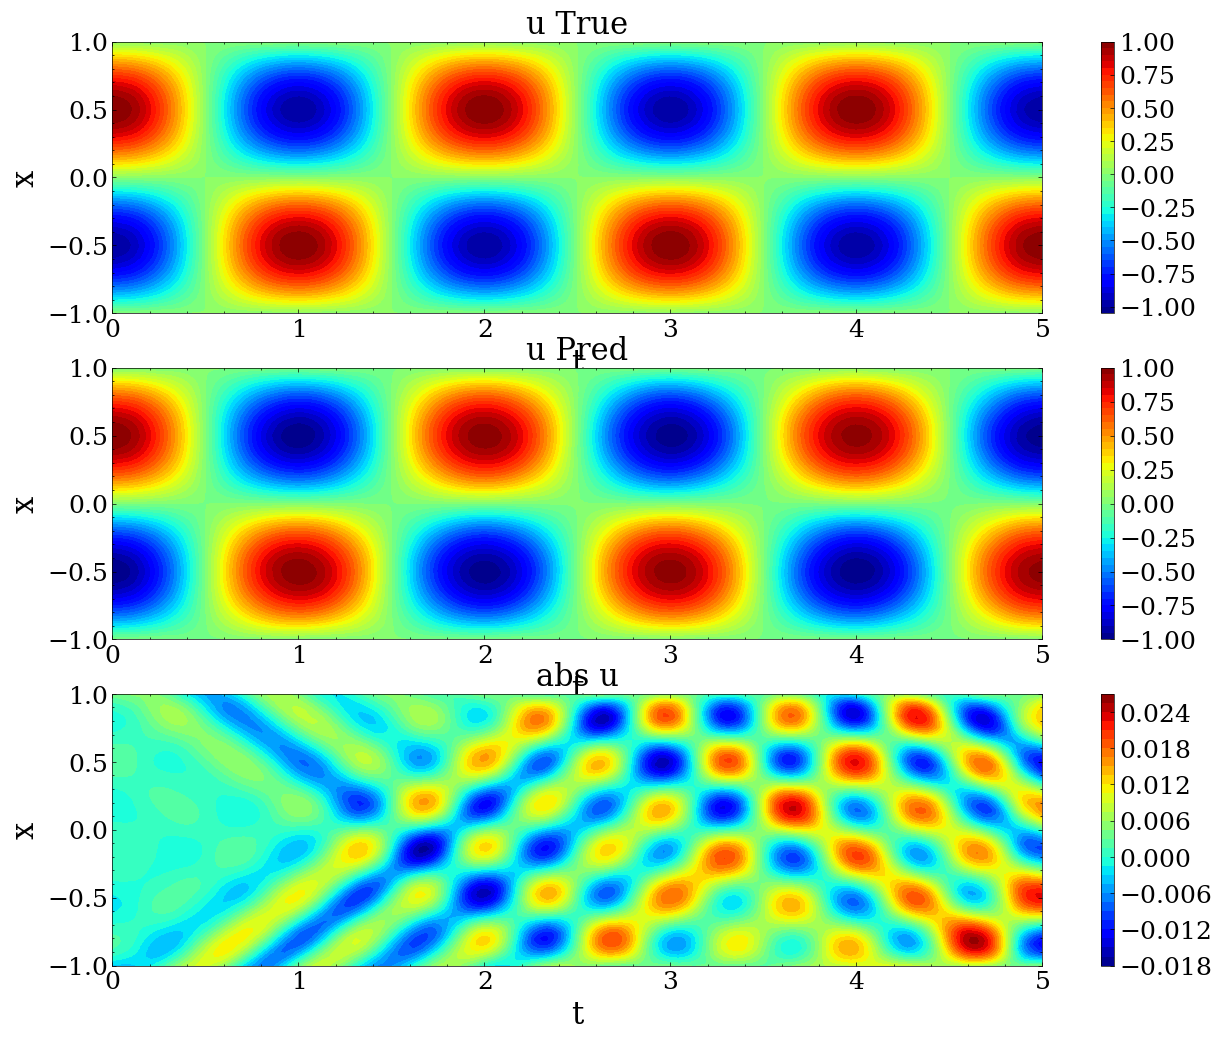

In [4]:
from torch.autograd import grad, Variable
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN_Time
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/1d/', name='model_particlewnn_final')

###############################
# make prediction
###############################
xt_var = Variable(xt_test, requires_grad=True).to(device)
u_var = model_trained['u'](xt_var)
u_var = u_var.detach().cpu()
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_1dt_list(xt_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'], tT=[tT])